# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [92]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [94]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [95]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [96]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''
    x = np.array(x)
    y = np.array(y)

    n = len(y)
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]

    n_test = int(n * pct)
    x_test = x[:n_test]
    y_test = y[:n_test]
    x_val  = x[n_test:]
    y_val  = y[n_test:]
    return x_val, y_val, x_test, y_test

In [97]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [98]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

In [99]:
x_mean = x_train.mean()
x_std  = x_train.std() + 1e-8

x_train = (x_train - x_mean) / x_std
x_val   = (x_val   - x_mean) / x_std
x_test  = (x_test  - x_mean) / x_std

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(27455, 784) (27455,) (3586, 784) (3586,) (3586, 784) (3586,)


### Graficar muestras

In [100]:
def plot_number(img_28x28):
    plt.figure()
    plt.imshow(img_28x28, cmap='gray')
    plt.axis('off')
    plt.show()

Etiqueta: 20


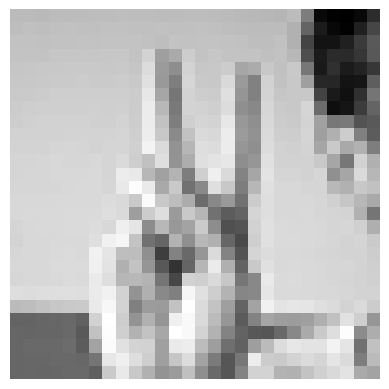

In [101]:
i = np.random.randint(len(x_train))
img = x_train[i].reshape(28, 28)
label = y_train[i]

print("Etiqueta:", label)
plot_number(img)

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [102]:
def create_minibatches(mb_size, x, y, shuffle=True):
    n = len(y)
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, n, mb_size):
        batch_idx = idx[i:i+mb_size]
        yield x[batch_idx], y[batch_idx]

In [103]:
class np_tensor(np.ndarray): pass

In [104]:
a = np.array([0, 0])
b = a.view(np_tensor)

## Nuestra clase Linear, ReLU y Sequential

###  Clase Linear

In [105]:
class Linear:
    def __init__(self, in_features, out_features):
        # Kaiming He
        self.W = (np.random.randn(out_features, in_features) / np.sqrt(in_features/2)).view(np_tensor)
        self.b = (np.zeros((out_features, 1))).view(np_tensor)

    def __call__(self, X): # foward de la clase Linear 
        Z = self.W @ X + self.b 
        return Z

    def backward(self, X, Z):
        # Z.grad viene definido desde la capa siguiente
        X.grad = self.W.T @ Z.grad
        self.W.grad = (Z.grad @ X.T)
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)

### Clase ReLU

In [106]:
class ReLU:
    def __call__(self, Z):
        return np.maximum(0, Z)

    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [107]:
class Sequential_layers:
    def __init__(self, layers):
        self.layers = layers
        self.outputs = {}

    def __call__(self, X):
        self.outputs['l0'] = X
        out = X
        for i, layer in enumerate(self.layers, start=1):
            out = layer(out)
            self.outputs[f'l{i}'] = out
        return out

    def backward(self):
        # recorre en reversa
        for i in range(len(self.layers), 0, -1):
            layer = self.layers[i-1]
            inp = self.outputs[f'l{i-1}']
            out = self.outputs[f'l{i}']
            layer.backward(inp, out)

    def update(self, lr):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.W = (layer.W - lr * layer.W.grad).view(np_tensor)
                layer.b = (layer.b - lr * layer.b.grad).view(np_tensor)

    def predict(self, x_col):
        scores = self(x_col.view(np_tensor))
        return int(np.argmax(scores, axis=0)[0])

### Cost Function

In [108]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()

    return preds, cost

### Loop de entrenamiento

In [109]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    # Train the model for a given number of epochs using mini-batch SGD.
    # Notes:
    # - 'scores' are the logits returned by the model.
    # - softmaxXEntropy(scores, y) computes the loss and seeds scores.grad.
    # - model.backward() backpropagates through all layers.
    # - model.update(learning_rate) applies an SGD step to parameters.
    for epoch in range(epochs):
        # Iterate over training data in mini-batches
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            # Forward pass: model expects (features, batch), so we transpose the batch
            scores = model(x.T.view(np_tensor))
            # Compute softmax cross-entropy loss and seed gradient on the final scores
            _, cost = softmaxXEntropy(scores, y)
            # Backpropagate gradients through the network
            model.backward()
            # Update parameters with the chosen learning rate
            model.update(learning_rate)
        # Friendly, English summary per epoch (shows the last batch loss and current validation accuracy)
        print(f"Epoch {epoch+1}/{epochs} — Last batch loss: {cost:.4f} | "
              f"Validation accuracy: {accuracy(x_val, y_val, mb_size)*100:.2f}%")

In [110]:
def accuracy(x, y, mb_size):
    # Initialize counters for correct predictions and total samples
    correct = 0
    total = 0

    # Iterate over the dataset in mini-batches
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        # Forward pass: the model expects input shaped as (features, batch), so we transpose
        pred = model(x.T.view(np_tensor))

        # Count how many predictions match the true labels
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())

        # Increase the total number of processed samples (batch size)
        total += pred.shape[1]

    # Return overall accuracy as correct predictions divided by total samples
    return correct/total

### Create your model and train it

In [111]:
model = Sequential_layers([Linear(784, 256), ReLU(), Linear(256, 128), ReLU(), Linear(128, 24)])
mb_size = 512
learning_rate = 1e-3
epochs = 25


In [112]:
train(model, epochs, mb_size, learning_rate)

Epoch 1/25 — Last batch loss: 0.3210 | Validation accuracy: 75.57%
Epoch 2/25 — Last batch loss: 0.0258 | Validation accuracy: 78.89%
Epoch 3/25 — Last batch loss: 0.0120 | Validation accuracy: 79.64%
Epoch 4/25 — Last batch loss: 0.0073 | Validation accuracy: 80.09%
Epoch 5/25 — Last batch loss: 0.0049 | Validation accuracy: 79.78%
Epoch 6/25 — Last batch loss: 0.0046 | Validation accuracy: 79.95%
Epoch 7/25 — Last batch loss: 0.0030 | Validation accuracy: 80.15%
Epoch 8/25 — Last batch loss: 0.0029 | Validation accuracy: 80.28%
Epoch 9/25 — Last batch loss: 0.0023 | Validation accuracy: 80.12%
Epoch 10/25 — Last batch loss: 0.0020 | Validation accuracy: 80.26%
Epoch 11/25 — Last batch loss: 0.0014 | Validation accuracy: 80.34%
Epoch 12/25 — Last batch loss: 0.0016 | Validation accuracy: 80.54%
Epoch 13/25 — Last batch loss: 0.0013 | Validation accuracy: 80.54%
Epoch 14/25 — Last batch loss: 0.0013 | Validation accuracy: 80.62%
Epoch 15/25 — Last batch loss: 0.0013 | Validation accura

In [113]:
# Compute test accuracy with mini-batches
test_acc = accuracy(x_test, y_test, mb_size)

# Nicely formatted output
print(f"TEST ACCURACY: {test_acc * 100:.2f}% ({test_acc:.4f})")

TEST ACCURACY: 80.03% (0.8003)


### Test your model on Random data from your test set

In [114]:
def test_random_samples(n=5, seed=None):
    """
    Run n random prediction tests on the test set.
    
    Parameters
    ----------
    n : int
        Number of random samples to test.
    seed : int or None
        Optional random seed for reproducibility.
    """
    if seed is not None:
        np.random.seed(seed)

    correct = 0

    for t in range(1, n + 1):
        # Pick a random test sample index
        idx = np.random.randint(len(y_test))

        # Visualize the corresponding 28x28 grayscale image
        plot_number(x_test[idx].reshape(28, 28))

        # Prepare the sample as a column vector (features, 1) and get the predicted class index
        pred = model.predict(x_test[idx].reshape(-1, 1))

        # Map class indices to letters for readability
        pred_letter = alphabet[pred]
        true_letter = alphabet[y_test[idx]]

        # Determine if the prediction matches the ground truth
        status = "CORRECT" if pred == y_test[idx] else "INCORRECT"
        correct += (status == "CORRECT")

        # Print a clear, uppercase status along with predicted vs. true labels
        print(f"[{t}/{n}] PREDICTION: {pred_letter} | TRUE: {true_letter} | STATUS: {status}")

    # Summary of the mini test session
    print(f"\nSUMMARY: {correct}/{n} correct "
          f"({100.0 * correct / max(1, n):.2f}% accuracy over random samples)")


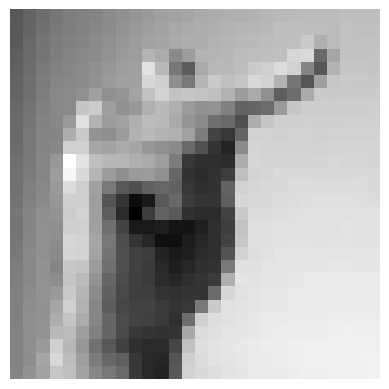

[1/10] PREDICTION: t | TRUE: t | STATUS: CORRECT


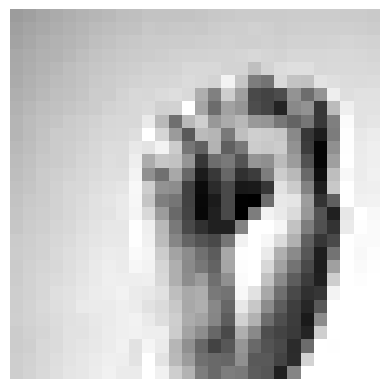

[2/10] PREDICTION: m | TRUE: s | STATUS: INCORRECT


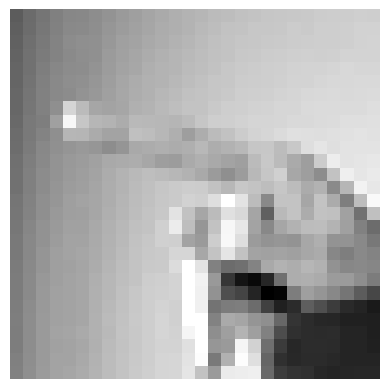

[3/10] PREDICTION: p | TRUE: p | STATUS: CORRECT


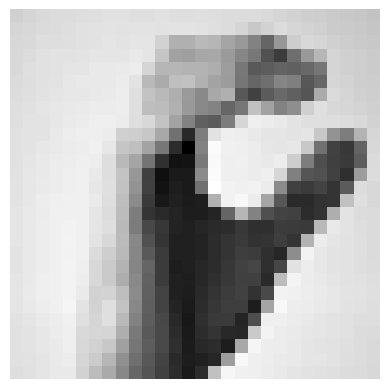

[4/10] PREDICTION: c | TRUE: c | STATUS: CORRECT


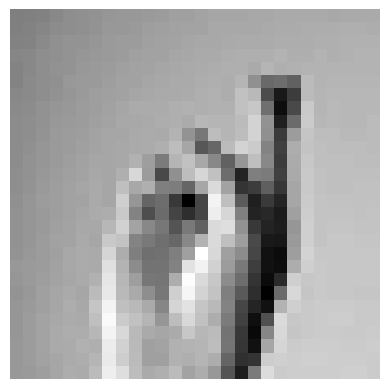

[5/10] PREDICTION: r | TRUE: r | STATUS: CORRECT


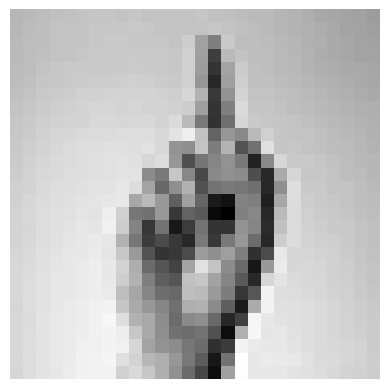

[6/10] PREDICTION: d | TRUE: d | STATUS: CORRECT


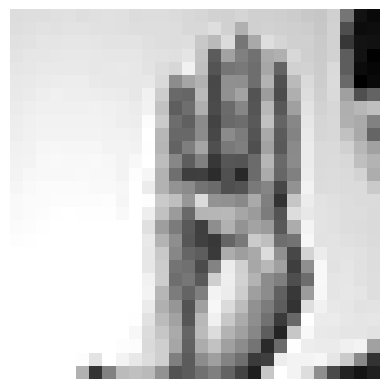

[7/10] PREDICTION: b | TRUE: b | STATUS: CORRECT


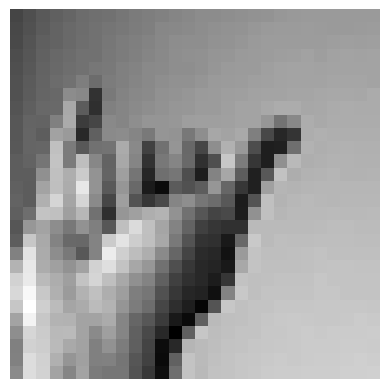

[8/10] PREDICTION: y | TRUE: y | STATUS: CORRECT


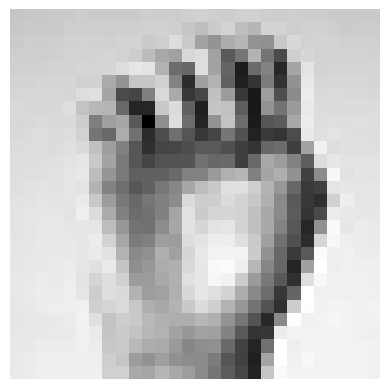

[9/10] PREDICTION: e | TRUE: e | STATUS: CORRECT


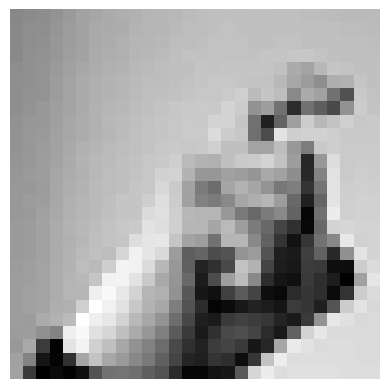

[10/10] PREDICTION: x | TRUE: x | STATUS: CORRECT

SUMMARY: 9/10 correct (90.00% accuracy over random samples)


In [115]:
test_random_samples(n=10, seed=42)